In [2]:
!pip install torch torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\D\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/110.9 MB 2.7 MB/s eta 0:00:42
   ---------------------------------------- 1.0/110.9 MB 2.1 MB/s eta 0:00:52
   ---------------------------------------- 1.3/110.9 MB 1.9 MB/s eta 0:00:57
    --------------------------------------- 1.8/110.9 MB 2.1 MB/s eta 0:00:52
    --------------------------------------- 2.1/110.9 MB 2.0 MB/s eta 0:00:55
    --------------------------------------- 2.6/110.9 MB 2.0 MB/s eta 0:00:56
   - -------------------------------------- 3.1/110.9 MB 2.1 MB/s eta 0:00:53
   - -------------------------------------- 3.7/110.9 MB 2.2 MB/s eta 0:00:50
   - -------------------------------------- 4.5/110.9 MB 2.3 MB/s eta 0:00:46
   - -------------------------------------- 5.2/110.9 MB 2.5 MB/s eta 0:00:43


In [95]:
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(0.13 , 0.31),
                                      transforms.RandomRotation(30),
                                      transforms.RandomAffine(10 , translate= (0.1 , 0.1))
                                     ])
transform_test = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(0.13 , 0.31)])


dataset_train = torchvision.datasets.MNIST(root="data",
                                           train = True,
                                           download = True,
                                           transform = transform_train)

dataset_test = torchvision.datasets.MNIST(root="data",
                                           train = False,
                                           download = True,
                                           transform = transform_test)



##Test DataSet

torch.Size([1, 28, 28])
1


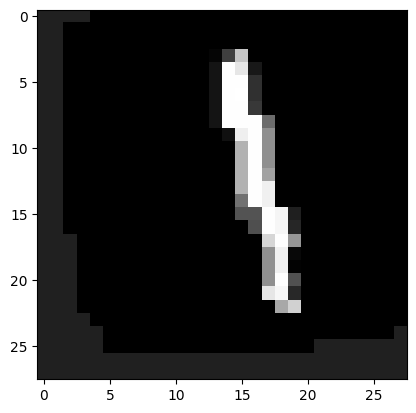

In [104]:
idx = 8
print(dataset_train[idx][0].size())
plt.imshow(dataset_train[idx][0].permute(1,2,0) , cmap="gray")
print(dataset_train[idx][1])

In [105]:
28 * 28

784

##Data Loader

In [102]:
dataloader_train = torch.utils.data.DataLoader(dataset_train , batch_size=64 , shuffle = True , num_workers=2)
dataloader_test = torch.utils.data.DataLoader(dataset_test , batch_size=64 , shuffle = False , num_workers=2)

In [112]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784 , 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512 , 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128 , 10),
)

In [113]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [120]:
optimizer = torch.optim.Adam(model.parameters())
loss_function = torch.nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [115]:
from tqdm import tqdm_notebook as tqdm

In [119]:
model(dataset_train[idx][0])

tensor([[-0.0497, -0.0095,  0.0148,  0.0416,  0.0266, -0.0254,  0.1075, -0.0654,
         -0.0871,  0.0397]], grad_fn=<AddmmBackward0>)

In [122]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [166]:
train_loss = []
train_acc = []
test_acc = []
test_loss = []


for epoch in range(30):
  model.train()
  pbar = tqdm(dataloader_train , desc = f"Training epoch {epoch + 1}")

  sum_correct = 0
  sum_sample = 0
  sum_loss = 0
  for x , y in pbar:
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()

    output = model(x)
    loss_value = loss_function(output , y)
    pbar.set_postfix_str(f"Loss = {loss_value:.3f}")
    loss_value.backward()
    optimizer.step()


    sum_correct += (output.argmax(axis = 1) == y).sum().item()
    sum_sample += len(y)
    sum_loss += loss_value * len(y)

  train_loss.append(sum_loss / sum_sample)
  train_acc.append(sum_correct / sum_sample)
  print(f"Average train loss: {sum_loss / sum_sample:.4f}")
  print(f"Average train Accuracy: {sum_correct / sum_sample:.4f}")
  print("--------------------------------")

  pbar = tqdm(dataloader_test , desc  = f"Testing in epoch {epoch + 1}" )

  for x , y in pbar:
    model.eval()
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
        output = model(x)
        loss_value = loss_function(output , y)
        pbar.set_postfix_str(f"Loss = {loss_value:.3f}")
        sum_sample += len(y)
        sum_loss += loss_value.item() * len(y)
        sum_correct += (y == output.argmax(axis = 1)).sum().item()

  test_loss.append((sum_loss / sum_sample))
  test_acc.append((sum_correct/sum_sample))
  print(f"Average test loss: {sum_loss / sum_sample :.4f}")
  print(f"Average test Accuracy: {sum_correct / sum_sample:.4f}")
  print("--------------------------------")



/tmp/ipython-input-1687616785.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(dataloader_train , desc = f"Training epoch {epoch + 1}")


Training epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Average train loss: 0.1169
Average train Accuracy: 0.9640
--------------------------------


/tmp/ipython-input-1687616785.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(dataloader_test , desc  = f"Testing in epoch {epoch + 1}" )


Testing in epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

Average test loss: 0.1118
Average test Accuracy: 0.9657
--------------------------------


Training epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Average train loss: 0.1137
Average train Accuracy: 0.9643
--------------------------------


Testing in epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

Average test loss: 0.1057
Average test Accuracy: 0.9669
--------------------------------


Training epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Average train loss: 0.1092
Average train Accuracy: 0.9655
--------------------------------


Testing in epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

Average test loss: 0.1017
Average test Accuracy: 0.9679
--------------------------------


Training epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

Average train loss: 0.1097
Average train Accuracy: 0.9662
--------------------------------


Testing in epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

Average test loss: 0.1027
Average test Accuracy: 0.9682
--------------------------------


Training epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]

Average train loss: 0.1047
Average train Accuracy: 0.9668
--------------------------------


Testing in epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

Average test loss: 0.0989
Average test Accuracy: 0.9686
--------------------------------


Training epoch 6:   0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [168]:
train_loss

[tensor(0.1169, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1137, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1092, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1097, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1047, device='cuda:0', grad_fn=<DivBackward0>)]

In [170]:
test_loss = list(map(lambda x:x.item() , test_loss))
train_loss = list(map(lambda x:x.item() , train_loss))

Text(0, 0.5, 'Epoch')

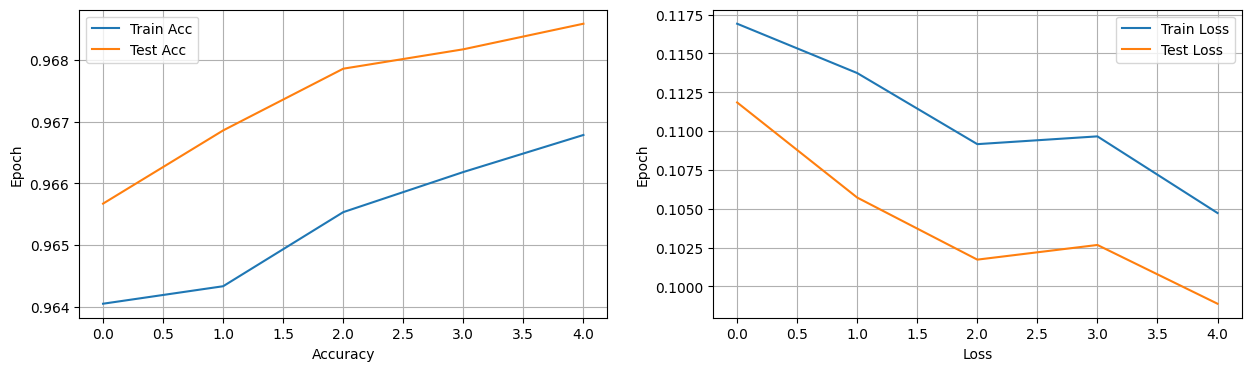

In [174]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(train_acc , label = "Train Acc")
plt.plot(test_acc , label = "Test Acc")
plt.grid()
plt.legend()
plt.xlabel("Accuracy")
plt.ylabel("Epoch")

plt.subplot(1,2,2)
plt.plot(train_loss , label = "Train Loss")
plt.plot(test_loss , label = "Test Loss")
plt.grid()
plt.legend()
plt.xlabel("Loss")
plt.ylabel("Epoch")



In [202]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import numpy as np
import torch
from PIL import Image

class MatplotlibDrawingApp:
    def __init__(self, model, transform, device):
        self.model = model
        self.transform = transform
        self.device = device

        # ساخت فیگور
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.fig.suptitle('بکش و پیش‌بینی کن!', fontsize=16)

        # ساخت canvas سیاه
        self.canvas = np.zeros((28, 28))
        self.img = self.ax.imshow(self.canvas, cmap='gray', vmin=0, vmax=1)
        self.ax.axis('off')

        # دکمه Predict
        ax_predict = plt.axes([0.3, 0.05, 0.2, 0.075])
        self.btn_predict = Button(ax_predict, 'Predict', color='lightgreen')
        self.btn_predict.on_clicked(self.predict)

        # دکمه Clear
        ax_clear = plt.axes([0.55, 0.05, 0.2, 0.075])
        self.btn_clear = Button(ax_clear, 'Clear', color='lightcoral')
        self.btn_clear.on_clicked(self.clear)

        # نتیجه
        self.result_text = self.fig.text(0.5, 0.92, '', ha='center', fontsize=14, color='blue')

        # Connect events
        self.drawing = False
        self.fig.canvas.mpl_connect('button_press_event', self.on_press)
        self.fig.canvas.mpl_connect('button_release_event', self.on_release)
        self.fig.canvas.mpl_connect('motion_notify_event', self.on_motion)

        plt.show()

    def on_press(self, event):
        if event.inaxes == self.ax:
            self.drawing = True

    def on_release(self, event):
        self.drawing = False

    def on_motion(self, event):
        if self.drawing and event.inaxes == self.ax:
            x, y = int(event.xdata), int(event.ydata)
            if 0 <= x < 28 and 0 <= y < 28:
                # کشیدن یه دایره کوچیک
                for i in range(-2, 3):
                    for j in range(-2, 3):
                        if 0 <= x+i < 28 and 0 <= y+j < 28:
                            if i*i + j*j <= 4:  # دایره
                                self.canvas[y+j, x+i] = 1.0

                self.img.set_data(self.canvas)
                self.fig.canvas.draw_idle()

    def predict(self, event):
        # تبدیل به PIL
        img_array = (self.canvas * 255).astype(np.uint8)
        img = Image.fromarray(img_array, mode='L')

        # Transform
        img_tensor = self.transform(img).unsqueeze(0).to(self.device)

        # Predict
        self.model.eval()
        with torch.no_grad():
            output = self.model(img_tensor)
            prediction = output.argmax(dim=1).item()
            probabilities = torch.softmax(output, dim=1)[0]
            confidence = probabilities[prediction].item() * 100

        self.result_text.set_text(f'پیش‌بینی: {prediction} (اطمینان: {confidence:.1f}%)')
        self.fig.canvas.draw_idle()

    def clear(self, event):
        self.canvas = np.zeros((28, 28))
        self.img.set_data(self.canvas)
        self.result_text.set_text('')
        self.fig.canvas.draw_idle()


# استفاده:
# %matplotlib widget  # برای Colab
# app = MatplotlibDrawingApp(model, transform_test, device)